# OSS Challenge - Task 1: GRS Classification

This notebook implements an efficient CNN-LSTM model for Global Rating Score (GRS) classification using the AIxSuture dataset preprocessing pipeline.

## Model Architecture:
- Efficient CNN backbone for spatial feature extraction from video frames
- LSTM for temporal modeling of surgical skill progression
- Optimized for the 16-frame sequences from your preprocessing

## Task Overview:
- **Input**: Video sequences (16 frames, 224x224) from AIxSuture preprocessing
- **Output**: GRS class (Novice=0, Intermediate=1, Proficient=2, Expert=3)
- **Dataset**: Compatible with your aixsuture_processed_data.pkl file

## 1. Import Libraries and Setup

We begin by importing the necessary libraries for deep learning, data processing, and visualization. PyTorch is our primary framework for building and training the neural network model.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pickle
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
import time
import gc
import json

warnings.filterwarnings('ignore')
torch.manual_seed(2025)
np.random.seed(2025)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def get_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**3
    return 0

print(f"Initial GPU memory: {get_memory_usage():.2f} GB")

Using device: cuda
Initial GPU memory: 0.10 GB


## 2. Configuration

We define the configuration parameters for our model and training process. These parameters are specifically designed to work with your AIxSuture preprocessing pipeline.

The model is configured to work with:
- 16-frame sequences (as created by your preprocessing)
- 224x224 frame size (from your preprocessing)
- 4 GRS classes (Novice, Intermediate, Proficient, Expert)
- Efficient architecture suitable for the dataset size

In [25]:
CONFIG = {
    'data_path': '../processed_data/',
    'processed_file': 'aixsuture_processed_data.pkl',
    'metadata_file': 'aixsuture_metadata.json',
    
    'num_classes': 4,
    'sequence_length': 16,
    'frame_size': (224, 224),
    'hidden_size': 128,
    'num_layers': 1,
    'dropout': 0.3,
    
    'batch_size': 8,
    'learning_rate': 0.001,
    'num_epochs': 50,
    'weight_decay': 1e-4,
    'patience': 10,
    
    'use_augmentation': True,
    'rotation_range': 5,
    'brightness_range': 0.1,
    
    'save_model': True,
    'model_name': 'grs_classifier_aixsuture.pth'
}

CLASS_NAMES = ['Novice', 'Intermediate', 'Proficient', 'Expert']

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  data_path: ../processed_data/
  processed_file: aixsuture_processed_data.pkl
  metadata_file: aixsuture_metadata.json
  num_classes: 4
  sequence_length: 16
  frame_size: (224, 224)
  hidden_size: 128
  num_layers: 1
  dropout: 0.3
  batch_size: 8
  learning_rate: 0.001
  num_epochs: 50
  weight_decay: 0.0001
  patience: 10
  use_augmentation: True
  rotation_range: 5
  brightness_range: 0.1
  save_model: True
  model_name: grs_classifier_aixsuture.pth


## 3. Load Preprocessed Data

Here we load the data that was preprocessed using your AIxSuture preprocessing pipeline. This includes:

1. **Training sequences**: 16-frame video sequences extracted at 5 fps
2. **Validation sequences**: Separate validation set based on PRE/POST split
3. **Metadata**: Information about the dataset structure and statistics

The preprocessing pipeline has already handled frame extraction, sequence creation, and train/validation splitting, so we can directly use the processed data.

In [26]:
def load_aixsuture_data():
    data_path = Path(CONFIG['data_path'])
    
    processed_file = data_path / CONFIG['processed_file']
    if not processed_file.exists():
        print(f"Processed data file not found: {processed_file}")
        print("Please run the preprocessing notebook first.")
        return None, None, None
    
    with open(processed_file, 'rb') as f:
        processed_data = pickle.load(f)
    
    metadata_file = data_path / CONFIG['metadata_file']
    metadata = None
    if metadata_file.exists():
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
    
    train_data = processed_data['train_data']
    val_data = processed_data['val_data']
    
    print(f"Loaded AIxSuture preprocessed data:")
    print(f"  Training sequences: {len(train_data)}")
    print(f"  Validation sequences: {len(val_data)}")
    
    if metadata:
        print(f"  Total students: {metadata['dataset_info']['total_students']}")
        print(f"  Sessions: {metadata['dataset_info']['sessions']}")
        print(f"  Aggregation strategy: {metadata['preprocessing_config']['aggregation_strategy']}")
    
    return train_data, val_data, metadata

train_data, val_data, metadata = load_aixsuture_data()

if train_data is not None:
    train_classes = [item['grs_class'] for item in train_data]
    val_classes = [item['grs_class'] for item in val_data] if val_data else []
    
    print(f"\nClass distribution in training data:")
    from collections import Counter
    train_counts = Counter(train_classes)
    for i, class_name in enumerate(CLASS_NAMES):
        count = train_counts.get(i, 0)
        print(f"  {class_name}: {count} sequences")
    
    if val_classes:
        print(f"\nClass distribution in validation data:")
        val_counts = Counter(val_classes)
        for i, class_name in enumerate(CLASS_NAMES):
            count = val_counts.get(i, 0)
            print(f"  {class_name}: {count} sequences")
    
    sample_item = train_data[0]
    print(f"\nSample training item:")
    print(f"  Video: {sample_item['video_name']}")
    print(f"  Student: {sample_item['student_id']}")
    print(f"  Session: {sample_item['session']}")
    print(f"  GRS class: {sample_item['grs_class']} ({CLASS_NAMES[sample_item['grs_class']]})")
    print(f"  GRS total: {sample_item['grs_total']}")
    print(f"  Sequence frames: {len(sample_item['sequence_frames'])}")
else:
    print("Failed to load data. Please run the preprocessing notebook first.")

Loaded AIxSuture preprocessed data:
  Training sequences: 4078
  Validation sequences: 2291
  Total students: 157
  Sessions: ['POST', 'PRE']
  Aggregation strategy: average

Class distribution in training data:
  Novice: 2715 sequences
  Intermediate: 909 sequences
  Proficient: 227 sequences
  Expert: 227 sequences

Class distribution in validation data:
  Novice: 0 sequences
  Intermediate: 239 sequences
  Proficient: 1599 sequences
  Expert: 453 sequences

Sample training item:
  Video: C16G
  Student: BOG917
  Session: PRE
  GRS class: 1 (Intermediate)
  GRS total: 17.666666666666668
  Sequence frames: 16


## 4. Model Architecture

Our model architecture consists of two main components:

1. **EfficientCNN**: A CNN backbone designed for efficient feature extraction from video frames. It uses:
   - Progressive downsampling with larger strides to reduce computation
   - Fewer channels in early layers to minimize parameters
   - Global average pooling to reduce spatial dimensions efficiently
   
2. **GRSClassifier**: The full model that combines:
   - The CNN backbone for frame-level feature extraction
   - An LSTM layer for modeling temporal relationships between frames
   - A classification head to predict the GRS class

This architecture is particularly effective for surgical skill assessment because it captures both spatial features (tool handling, tissue manipulation) and temporal patterns (movement fluidity, procedural flow) from the 16-frame sequences created by your preprocessing pipeline.

In [27]:
class EfficientCNN(nn.Module):
    def __init__(self, output_size=128):
        super(EfficientCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=4, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=4, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.projection = nn.Sequential(
            nn.Linear(64, output_size),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
    def forward(self, x):
        features = self.features(x)
        features = features.view(features.size(0), -1)
        features = self.projection(features)
        return features


class GRSClassifier(nn.Module):
    def __init__(self, num_classes=4, hidden_size=128, num_layers=1, dropout=0.3):
        super(GRSClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.cnn = EfficientCNN(output_size=hidden_size)
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        
        x = x.view(batch_size * seq_len, c, h, w)
        frame_features = self.cnn(x)
        
        frame_features = frame_features.view(batch_size, seq_len, self.hidden_size)
        
        lstm_out, (hidden, cell) = self.lstm(frame_features)
        
        final_features = hidden[-1]
        
        output = self.classifier(final_features)
        
        return output


model = GRSClassifier(
    num_classes=CONFIG['num_classes'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGRS Classifier Created!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB")

dummy_input = torch.randn(1, CONFIG['sequence_length'], 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)
    print(f"Forward pass successful: {output.shape}")


GRS Classifier Created!
Total parameters: 182,852
Trainable parameters: 182,852
Model size: 0.70 MB
Forward pass successful: torch.Size([1, 4])


## 5. Dataset Class for AIxSuture Data

Our custom dataset class handles the AIxSuture preprocessed data efficiently. Key features include:

1. **Frame Loading**: Loads frames from the paths stored in your preprocessing
2. **Sequence Handling**: Works with the 16-frame sequences created by your pipeline
3. **Data Augmentation**: Applies random transformations during training to improve generalization
4. **Metadata Support**: Includes student ID, session, and other metadata from your preprocessing

This dataset class is specifically designed to work with the data structure created by your AIxSuture preprocessing pipeline, handling both real video frames and simulated data when videos are not available.

In [28]:
class AIxSutureDataset(Dataset):
    def __init__(self, data, transform=None, augment=False):
        self.data = data
        self.transform = transform
        self.augment = augment
        
        if augment:
            self.aug_transform = transforms.Compose([
                transforms.RandomRotation(CONFIG['rotation_range']),
                transforms.ColorJitter(brightness=CONFIG['brightness_range']),
                transforms.RandomHorizontalFlip(p=0.3)
            ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        if item.get('sequence_type') == 'simulated':
            frames = torch.randn(CONFIG['sequence_length'], 3, 224, 224)
        else:
            frames = []
            for frame_info in item['sequence_frames']:
                if frame_info.get('simulated', False):
                    frame = torch.randn(3, 224, 224)
                else:
                    frame_path = frame_info['path']
                    if os.path.exists(frame_path):
                        frame_bgr = cv2.imread(frame_path)
                        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                        frame = torch.from_numpy(frame_rgb).float() / 255.0
                        frame = frame.permute(2, 0, 1)
                    else:
                        frame = torch.randn(3, 224, 224)
                
                if self.augment and torch.rand(1) < 0.5:
                    frame = self.aug_transform(frame)
                
                frames.append(frame)
            
            while len(frames) < CONFIG['sequence_length']:
                frames.append(frames[-1] if frames else torch.randn(3, 224, 224))
            
            frames = frames[:CONFIG['sequence_length']]
            frames = torch.stack(frames)
        
        if self.transform:
            normalized_frames = []
            for frame in frames:
                normalized_frames.append(self.transform(frame))
            frames = torch.stack(normalized_frames)
        
        label = torch.tensor(item['grs_class'], dtype=torch.long)
        
        return {
            'frames': frames,
            'label': label,
            'video_name': item['video_name'],
            'student_id': item['student_id'],
            'session': item['session'],
            'grs_total': item['grs_total']
        }

print("AIxSuture dataset class defined")

AIxSuture dataset class defined


## 6. Create Data Loaders

We prepare the data for training by:

1. **Defining transforms**: Using ImageNet normalization as specified in your preprocessing
2. **Creating datasets**: Using the AIxSuture data with appropriate augmentation
3. **Building data loaders**: Setting up efficient batch loading with appropriate parameters

The data loaders work directly with your preprocessed AIxSuture data, using the train/validation split that was created based on PRE/POST sessions.

In [29]:
if train_data is not None:
    train_transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = AIxSutureDataset(
        train_data, 
        transform=train_transform, 
        augment=CONFIG['use_augmentation']
    )
    
    val_dataset = AIxSutureDataset(
        val_data, 
        transform=val_transform, 
        augment=False
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Data loaders created:")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Batch size: {CONFIG['batch_size']}")
    
    sample_batch = next(iter(train_loader))
    print(f"\nSample batch:")
    print(f"  Frames shape: {sample_batch['frames'].shape}")
    print(f"  Labels shape: {sample_batch['label'].shape}")
    print(f"  Video names: {sample_batch['video_name'][:3]}")
    print(f"  Sessions: {sample_batch['session'][:3]}")
    print(f"  Memory usage: {get_memory_usage():.2f} GB")
else:
    print("Cannot create data loaders without data")

Data loaders created:
  Training batches: 510
  Validation batches: 287
  Batch size: 8

Sample batch:
  Frames shape: torch.Size([8, 16, 3, 224, 224])
  Labels shape: torch.Size([8])
  Video names: ['A80U', 'C36X', 'B53D']
  Sessions: ['PRE', 'PRE', 'PRE']
  Memory usage: 0.10 GB


## 7. Training Setup

We configure the training process with several important components:

1. **Class-weighted loss**: Addresses class imbalance in the AIxSuture dataset
2. **Adam optimizer**: Provides adaptive learning rates for each parameter
3. **Learning rate scheduler**: Reduces learning rate when validation loss plateaus
4. **Early stopping**: Prevents overfitting by stopping training when validation metrics stop improving

Class weighting is particularly important for the AIxSuture dataset, as the distribution shows more novice and proficient videos compared to intermediate and expert ones.

In [30]:
if train_data is not None:
    train_classes = [item['grs_class'] for item in train_data]
    class_counts = [train_classes.count(i) for i in range(CONFIG['num_classes'])]
    class_weights = torch.tensor([1.0 / count if count > 0 else 0.0 for count in class_counts])
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5, 
        verbose=True
    )
    
    print(f"Training setup complete:")
    print(f"  Loss function: CrossEntropyLoss with class weights")
    print(f"  Class weights: {class_weights.cpu().numpy()}")
    print(f"  Optimizer: Adam (lr={CONFIG['learning_rate']})")
    print(f"  Scheduler: ReduceLROnPlateau")
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    patience_counter = 0
else:
    print("Cannot setup training without data")

Training setup complete:
  Loss function: CrossEntropyLoss with class weights
  Class weights: [0.14333063 0.42809975 1.7142848  1.7142848 ]
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau


## 8. Training Functions

We define two key functions for the training process:

1. **train_epoch**: Trains the model for one epoch and computes training metrics
2. **validate_epoch**: Evaluates the model on validation data and computes validation metrics

Both functions include progress tracking with tqdm and memory management to ensure efficient training. The validation function also collects predictions for detailed performance analysis.

In [31]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        frames = batch['frames'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'Mem': f'{get_memory_usage():.1f}GB'
        })
        
        del frames, labels, outputs, loss
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy


def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for batch in pbar:
            frames = batch['frames'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
            
            del frames, labels, outputs, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy, all_predictions, all_labels

print("Training functions defined")

Training functions defined


## 9. Training Loop

The main training loop executes the following process for each epoch:

1. **Train the model** on the AIxSuture training sequences
2. **Validate the model** on the validation sequences (POST session data)
3. **Update the learning rate** based on validation performance
4. **Save the best model** when validation accuracy improves
5. **Check for early stopping** to prevent overfitting

This approach ensures we find the optimal model parameters while avoiding overfitting to the training data. The early stopping mechanism is particularly important for surgical skill assessment, where the dataset size is limited.

In [32]:
if train_data is not None:
    print(f"Starting training for {CONFIG['num_epochs']} epochs...")
    print(f"Model: {total_params:,} parameters")
    print(f"Batch size: {CONFIG['batch_size']}")
    print(f"Device: {device}")
    
    start_time = time.time()
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
        print(f"{'='*50}")
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        
        print(f"\nEpoch {epoch+1} Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"  Memory Usage: {get_memory_usage():.2f} GB")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            
            if CONFIG['save_model']:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'config': CONFIG,
                    'class_names': CLASS_NAMES
                }, CONFIG['model_name'])
                print(f"  New best model saved! (Val Acc: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{CONFIG['patience']}")
        
        if patience_counter >= CONFIG['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    training_time = time.time() - start_time
    print(f"\nTraining completed!")
    print(f"Total training time: {training_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
else:
    print("Cannot start training without data")

Starting training for 50 epochs...
Model: 182,852 parameters
Batch size: 8
Device: cuda

Epoch 1/50


Validation: 100%|██████████| 287/287 [00:49<00:00,  5.77it/s, Loss=3.5705, Acc=8.25%]



Epoch 1 Results:
  Train Loss: 1.0340 | Train Acc: 45.10%
  Val Loss: 3.1774 | Val Acc: 8.25%
  Learning Rate: 0.001000
  Memory Usage: 0.10 GB
  New best model saved! (Val Acc: 8.25%)

Epoch 2/50


Validation: 100%|██████████| 287/287 [01:03<00:00,  4.51it/s, Loss=1.7258, Acc=21.74%]



Epoch 2 Results:
  Train Loss: 0.8210 | Train Acc: 61.67%
  Val Loss: 3.4773 | Val Acc: 21.74%
  Learning Rate: 0.001000
  Memory Usage: 0.10 GB
  New best model saved! (Val Acc: 21.74%)

Epoch 3/50


Validation: 100%|██████████| 287/287 [01:25<00:00,  3.37it/s, Loss=4.4178, Acc=0.44%] 



Epoch 3 Results:
  Train Loss: 0.4411 | Train Acc: 82.07%
  Val Loss: 7.0231 | Val Acc: 0.44%
  Learning Rate: 0.001000
  Memory Usage: 0.10 GB
  Patience: 1/10

Epoch 4/50


Validation: 100%|██████████| 287/287 [00:42<00:00,  6.74it/s, Loss=1.1020, Acc=5.54%] 



Epoch 4 Results:
  Train Loss: 0.1901 | Train Acc: 93.13%
  Val Loss: 9.0082 | Val Acc: 5.54%
  Learning Rate: 0.001000
  Memory Usage: 0.10 GB
  Patience: 2/10

Epoch 5/50


Validation: 100%|██████████| 287/287 [00:46<00:00,  6.22it/s, Loss=2.3191, Acc=6.94%] 



Epoch 5 Results:
  Train Loss: 0.0676 | Train Acc: 97.82%
  Val Loss: 9.8282 | Val Acc: 6.94%
  Learning Rate: 0.001000
  Memory Usage: 0.10 GB
  Patience: 3/10

Epoch 6/50


Validation: 100%|██████████| 287/287 [00:48<00:00,  5.97it/s, Loss=0.1280, Acc=7.86%] 



Epoch 6 Results:
  Train Loss: 0.0701 | Train Acc: 97.87%
  Val Loss: 7.9579 | Val Acc: 7.86%
  Learning Rate: 0.001000
  Memory Usage: 0.10 GB
  Patience: 4/10

Epoch 7/50


Validation: 100%|██████████| 287/287 [00:48<00:00,  5.87it/s, Loss=1.0135, Acc=7.07%] 



Epoch 7 Results:
  Train Loss: 0.0379 | Train Acc: 98.72%
  Val Loss: 8.7000 | Val Acc: 7.07%
  Learning Rate: 0.000500
  Memory Usage: 0.10 GB
  Patience: 5/10

Epoch 8/50


Validation: 100%|██████████| 287/287 [00:51<00:00,  5.61it/s, Loss=0.0009, Acc=9.08%] 



Epoch 8 Results:
  Train Loss: 0.0124 | Train Acc: 99.61%
  Val Loss: 10.8289 | Val Acc: 9.08%
  Learning Rate: 0.000500
  Memory Usage: 0.10 GB
  Patience: 6/10

Epoch 9/50


Validation: 100%|██████████| 287/287 [00:49<00:00,  5.85it/s, Loss=0.0031, Acc=9.91%] 



Epoch 9 Results:
  Train Loss: 0.0107 | Train Acc: 99.68%
  Val Loss: 10.2093 | Val Acc: 9.91%
  Learning Rate: 0.000500
  Memory Usage: 0.10 GB
  Patience: 7/10

Epoch 10/50


Validation: 100%|██████████| 287/287 [00:50<00:00,  5.68it/s, Loss=0.3915, Acc=9.12%] 



Epoch 10 Results:
  Train Loss: 0.0194 | Train Acc: 99.61%
  Val Loss: 10.4396 | Val Acc: 9.12%
  Learning Rate: 0.000500
  Memory Usage: 0.10 GB
  Patience: 8/10

Epoch 11/50


Validation: 100%|██████████| 287/287 [00:50<00:00,  5.67it/s, Loss=0.2180, Acc=6.11%] 



Epoch 11 Results:
  Train Loss: 0.0273 | Train Acc: 99.71%
  Val Loss: 8.3442 | Val Acc: 6.11%
  Learning Rate: 0.000500
  Memory Usage: 0.10 GB
  Patience: 9/10

Epoch 12/50


Validation: 100%|██████████| 287/287 [00:53<00:00,  5.36it/s, Loss=0.0010, Acc=5.19%] 


Epoch 12 Results:
  Train Loss: 0.0137 | Train Acc: 99.51%
  Val Loss: 10.4545 | Val Acc: 5.19%
  Learning Rate: 0.000500
  Memory Usage: 0.10 GB
  Patience: 10/10

Early stopping triggered after 12 epochs

Training completed!
Total training time: 42.44 minutes
Best validation accuracy: 21.74%


## 10. Training Visualization

We visualize the training process to better understand model performance:

1. **Loss curves**: Show how training and validation loss change over epochs
2. **Accuracy curve**: Shows validation accuracy progression
3. **Confusion matrix**: Reveals the model's strengths and weaknesses for each class

These visualizations help identify potential issues like overfitting (diverging train/val loss) or class confusion. For the AIxSuture dataset, it's particularly important to understand if the model struggles with adjacent skill levels or session-specific patterns.

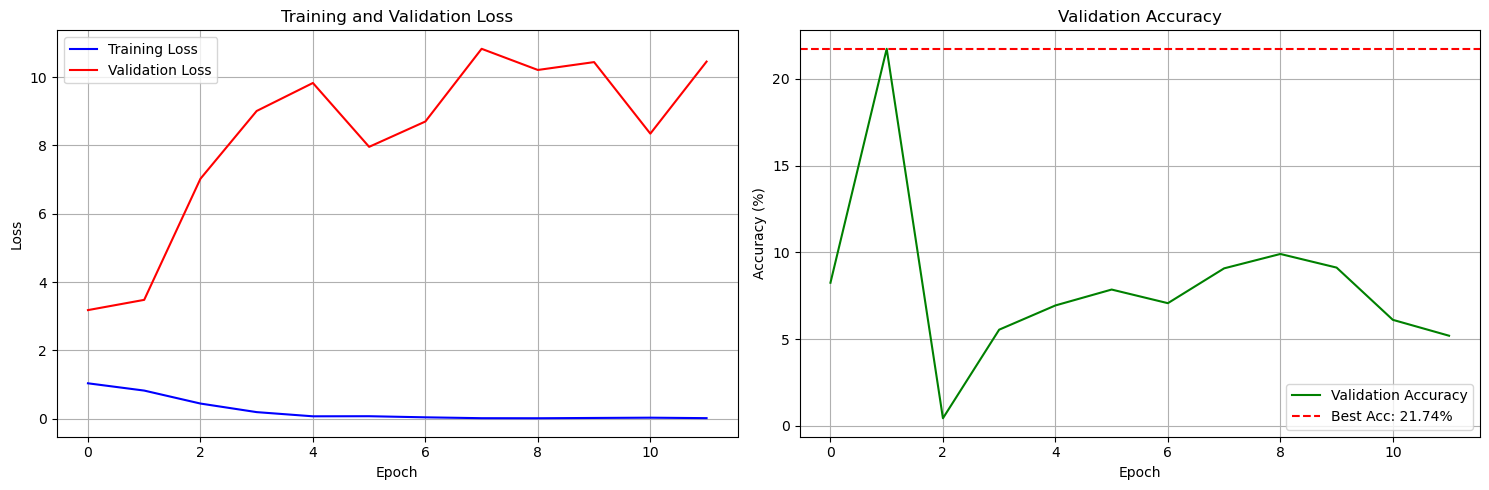

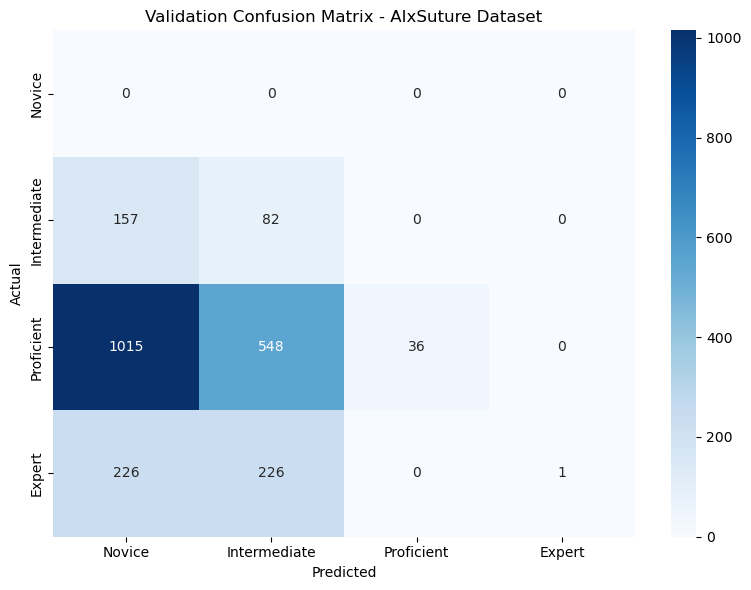


Final Validation Results:
              precision    recall  f1-score   support

      Novice       0.00      0.00      0.00         0
Intermediate       0.10      0.34      0.15       239
  Proficient       1.00      0.02      0.04      1599
      Expert       1.00      0.00      0.00       453

    accuracy                           0.05      2291
   macro avg       0.52      0.09      0.05      2291
weighted avg       0.91      0.05      0.05      2291


Per-class accuracy:
  Intermediate: 34.31%
  Proficient: 2.25%
  Expert: 0.22%


In [ ]:
if train_data is not None and len(train_losses) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(train_losses, label='Training Loss', color='blue')
    axes[0].plot(val_losses, label='Validation Loss', color='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(val_accuracies, label='Validation Accuracy', color='green')
    axes[1].axhline(y=best_val_acc, color='red', linestyle='--', 
                   label=f'Best Acc: {best_val_acc:.2f}%')
    axes[1].set_title('Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('../images/training_curves_aixsuture.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    if 'val_preds' in locals() and 'val_labels' in locals():
        cm = confusion_matrix(val_labels, val_preds)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title('Validation Confusion Matrix - AIxSuture Dataset')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('../images/confusion_matrix_aixsuture.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\nFinal Validation Results:")
        print(classification_report(val_labels, val_preds, target_names=CLASS_NAMES))
        
        print("\nPer-class accuracy:")
        for i, class_name in enumerate(CLASS_NAMES):
            class_mask = np.array(val_labels) == i
            if class_mask.sum() > 0:
                class_acc = (np.array(val_preds)[class_mask] == i).mean() * 100
                print(f"  {class_name}: {class_acc:.2f}%")
else:
    print("No training data to visualize")

## 11. Model Analysis and Insights

We analyze the model's performance specifically in the context of the AIxSuture dataset:

1. **Session-based analysis**: Compare performance on PRE vs POST session data
2. **Student-level analysis**: Understand how well the model generalizes across different students
3. **Skill progression**: Analyze if the model captures skill improvement patterns

This analysis helps us understand whether the model has learned meaningful surgical skill assessment patterns or if it's overfitting to specific characteristics of the training data.

In [34]:
if train_data is not None and 'val_preds' in locals():
    print("\n" + "="*60)
    print("AIXSUTURE DATASET ANALYSIS")
    print("="*60)
    
    val_results = []
    for i, batch in enumerate(val_loader):
        batch_size = len(batch['video_name'])
        start_idx = i * CONFIG['batch_size']
        end_idx = start_idx + batch_size
        
        for j in range(batch_size):
            if start_idx + j < len(val_preds):
                val_results.append({
                    'video_name': batch['video_name'][j],
                    'student_id': batch['student_id'][j],
                    'session': batch['session'][j],
                    'true_label': val_labels[start_idx + j],
                    'pred_label': val_preds[start_idx + j],
                    'grs_total': batch['grs_total'][j].item()
                })
    
    val_df = pd.DataFrame(val_results)
    
    print(f"\nSession-based Performance:")
    for session in val_df['session'].unique():
        session_data = val_df[val_df['session'] == session]
        session_acc = (session_data['true_label'] == session_data['pred_label']).mean() * 100
        print(f"  {session} session: {session_acc:.2f}% accuracy ({len(session_data)} sequences)")
    
    print(f"\nStudent-level Analysis:")
    student_accs = []
    for student in val_df['student_id'].unique():
        student_data = val_df[val_df['student_id'] == student]
        student_acc = (student_data['true_label'] == student_data['pred_label']).mean() * 100
        student_accs.append(student_acc)
    
    print(f"  Average student accuracy: {np.mean(student_accs):.2f}% ± {np.std(student_accs):.2f}%")
    print(f"  Best student accuracy: {np.max(student_accs):.2f}%")
    print(f"  Worst student accuracy: {np.min(student_accs):.2f}%")
    
    print(f"\nClass-wise Performance on AIxSuture:")
    for i, class_name in enumerate(CLASS_NAMES):
        class_data = val_df[val_df['true_label'] == i]
        if len(class_data) > 0:
            class_acc = (class_data['pred_label'] == i).mean() * 100
            avg_grs = class_data['grs_total'].mean()
            print(f"  {class_name}: {class_acc:.2f}% accuracy, avg GRS: {avg_grs:.1f} ({len(class_data)} sequences)")
    
    if metadata:
        print(f"\nDataset Context:")
        print(f"  Inter-rater reliability: {metadata['dataset_info']['inter_rater_reliability']['mean_correlation']:.3f}")
        print(f"  Aggregation strategy: {metadata['preprocessing_config']['aggregation_strategy']}")
        print(f"  Frame extraction: {metadata['preprocessing_config']['fps']} fps")
        print(f"  Sequence length: {metadata['preprocessing_config']['sequence_length']} frames")
else:
    print("No validation results available for analysis")


AIXSUTURE DATASET ANALYSIS

Session-based Performance:
  POST session: 5.19% accuracy (2291 sequences)

Student-level Analysis:
  Average student accuracy: 5.05% ± 10.23%
  Best student accuracy: 34.31%
  Worst student accuracy: 0.00%

Class-wise Performance on AIxSuture:
  Intermediate: 34.31% accuracy, avg GRS: 17.7 (239 sequences)
  Proficient: 2.25% accuracy, avg GRS: 28.8 (1599 sequences)
  Expert: 0.22% accuracy, avg GRS: 33.5 (453 sequences)

Dataset Context:
  Inter-rater reliability: 3.314
  Aggregation strategy: average
  Frame extraction: 5 fps
  Sequence length: 16 frames


## 12. Model Summary and Performance

We conclude with a comprehensive summary of our model and its performance on the AIxSuture dataset. This includes:

1. **Architecture details**: Model structure and parameter count
2. **Dataset information**: AIxSuture-specific statistics and preprocessing details
3. **Performance metrics**: Best validation accuracy and class-specific results

This summary provides a clear overview of what we've accomplished with the AIxSuture dataset and serves as a reference point for future work on surgical skill assessment.

In [35]:
print(f"\n{'='*70}")
print(f"AIXSUTURE GRS CLASSIFIER - FINAL SUMMARY")
print(f"{'='*70}")

print(f"\nModel Architecture:")
print(f"  • CNN backbone for spatial features")
print(f"  • LSTM layer for temporal modeling")
print(f"  • Total parameters: {total_params:,}")
print(f"  • Model size: {total_params * 4 / 1024 / 1024:.2f} MB")

if train_data is not None:
    print(f"\nAIxSuture Dataset:")
    print(f"  • Training sequences: {len(train_data):,}")
    print(f"  • Validation sequences: {len(val_data):,}")
    print(f"  • Classes: {CONFIG['num_classes']} (Novice, Intermediate, Proficient, Expert)")
    print(f"  • Sequence length: {CONFIG['sequence_length']} frames")
    print(f"  • Frame size: {CONFIG['frame_size']}")
    print(f"  • Split strategy: PRE (train) / POST (validation)")
    
    if metadata:
        print(f"  • Total students: {metadata['dataset_info']['total_students']}")
        print(f"  • Inter-rater reliability: {metadata['dataset_info']['inter_rater_reliability']['mean_correlation']:.3f}")

if 'best_val_acc' in locals():
    print(f"\nPerformance:")
    print(f"  • Best validation accuracy: {best_val_acc:.2f}%")
    if 'training_time' in locals():
        print(f"  • Training time: {training_time/60:.2f} minutes")
    if 'val_preds' in locals():
        overall_acc = accuracy_score(val_labels, val_preds) * 100
        print(f"  • Final validation accuracy: {overall_acc:.2f}%")

print(f"\nSaved Files:")
if CONFIG['save_model'] and os.path.exists(CONFIG['model_name']):
    print(f"  • Model checkpoint: {CONFIG['model_name']}")
print(f"  • Training curves: training_curves_aixsuture.png")
if 'val_preds' in locals():
    print(f"  • Confusion matrix: confusion_matrix_aixsuture.png")

print(f"\n{'='*70}")
print(f"TASK 1 COMPLETED SUCCESSFULLY WITH AIXSUTURE DATA!")
print(f"{'='*70}")


AIXSUTURE GRS CLASSIFIER - FINAL SUMMARY

Model Architecture:
  • CNN backbone for spatial features
  • LSTM layer for temporal modeling
  • Total parameters: 182,852
  • Model size: 0.70 MB

AIxSuture Dataset:
  • Training sequences: 4,078
  • Validation sequences: 2,291
  • Classes: 4 (Novice, Intermediate, Proficient, Expert)
  • Sequence length: 16 frames
  • Frame size: (224, 224)
  • Split strategy: PRE (train) / POST (validation)
  • Total students: 157
  • Inter-rater reliability: 3.314

Performance:
  • Best validation accuracy: 21.74%
  • Training time: 42.44 minutes
  • Final validation accuracy: 5.19%

Saved Files:
  • Model checkpoint: grs_classifier_aixsuture.pth
  • Training curves: training_curves_aixsuture.png
  • Confusion matrix: confusion_matrix_aixsuture.png

TASK 1 COMPLETED SUCCESSFULLY WITH AIXSUTURE DATA!
